In [369]:
import numpy as np
import math
from deap import base, creator, tools
import random
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
import json
import pandas as pd


## Visualização de escoamento


### Mapa de calor
0 - azul

1 - vermelho

eixo x,y e z (plano)

### Mapa de resultados numeros com vetores de mesmo tamanho


### Resultados numeros com linhas de corrente
- linhas de corrente: linhas tangentes a velocidade (somatorio). linha de tangete a linha do vetor velocidade (trajetoria da particula do vetor da velocidade)

[ ] Implementação do programa e simulaçoes

[ ] Coleta e analise de dados

- Ajustar os aleatórios do RCE.
- Utilizar estruturas do DEAP (individual) para as variáveis de decisão (verificar).
- Fazer backup da nova versão no drive

11ª Reunião (Remota)
- Verificar pendências
- Ajustar o RCE, seguindo passo a passo no chat do google.
- Utilizar estruturas do DEAP (individual) para as variáveis de decisão (verificar).
- Fazer backup da nova versão no drive
- Tipo, qtde e limite de variáveis de decisão são dados de entrada e impactam em ajuste da função individual do DEAP (isso será visto depois).
- Verificar se a explicação do resultado e os gráficos estão corretos.

## Classe Setup 

In [370]:
class Setup:
    def __init__(self, params):
        self.params = params
        self.CXPB = params["CROSSOVER"]
        self.MUTPB = params["MUTACAO"]
        self.NGEN = params["NUM_GENERATIONS"]
        self.POP_SIZE = params["POP_SIZE"]
        self.IND_SIZE = params["IND_SIZE"]
        self.CROSSOVER, self.MUTACAO, self.NUM_GENERATIONS, self.POPULATION_SIZE = (
            self.CXPB,
            self.MUTPB,
            self.NGEN, 
            self.POP_SIZE,
        )
        self.SIZE_INDIVIDUAL = self.IND_SIZE
        self.evaluations = 0
        self.num_repopulation = int(self.NUM_GENERATIONS * 0.20)
        self.type = params["type"].lower()
        if self.type == "maximize":
            print("Método escolhido: Maximizar")
            creator.create("Fitness", base.Fitness, weights=(1.0,))
        else:
            print("Método escolhido: Minimizar")
            creator.create("Fitness", base.Fitness, weights=(-1.0,))

        # creator.create("Individual", list, fitness=creator.Fitness)

        self.dataset = {}
        self.beta_constants = {}


        #!Criando invidivuo
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create(
            "Individual", list, fitness=creator.FitnessMin, rce=str, index=int
        )
        self.toolbox = base.Toolbox()
        # todo gerando atributos ao ind
        self.toolbox.register(
            "attr_rce", random.uniform, 0.0, 9.9
        )  
        self.toolbox.register("attr_int", random.uniform, 1, 1000)

        self.toolbox.register("attribute", random.uniform, -5.12, 5.12)
        self.toolbox.register(
            "individual",
            tools.initRepeat,
            creator.Individual,
            self.toolbox.attribute,
            n=self.SIZE_INDIVIDUAL,
        )

        #paramentos evolutivos
        self.toolbox.register(
            "population", tools.initRepeat, list, self.toolbox.individual
        )
        self.toolbox.register("mate", tools.cxTwoPoint)
        self.toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
        self.toolbox.register("select", tools.selTournament, tournsize=3)
        self.toolbox.register("evaluate", self.evaluate_fitness)

    def evaluate_fitness(self, individual):
        if self.type == "minimaze":
            result = minimize(self.rastrigin, x0=np.zeros(self.IND_SIZE), method="BFGS")
            fitness_value = result.fun
        return fitness_value

    def gerarDataset(self, excel):
        df = pd.read_excel(excel)
        print(df.columns)
        self.dataset = {
            "CXPB": self.CROSSOVER,
            "TAXA_MUTACAO": self.MUTACAO,
            "NUM_GEN": self.NUM_GENERATIONS,
            "POP_SIZE": self.POPULATION_SIZE,
            "IND_SIZE": self.SIZE_INDIVIDUAL,
            "evaluations": self.evaluations,
            "NUM_REPOPULATION": self.num_repopulation,
        }

    def rastrigin(self, individual):
        self.evaluations += 1
        rastrigin = 10 * self.SIZE_INDIVIDUAL
        for i in range(self.SIZE_INDIVIDUAL):
            rastrigin += individual[i] * individual[i] - 10 * (
                math.cos(2 * np.pi * individual[i])
            )
        return rastrigin

    def rastrigin_decisionVariables(self, individual, decision_variables):
        self.evaluations += 1
        rastrigin = 10 * len(decision_variables)
        for i in range(len(decision_variables)):
            rastrigin += individual[i] * individual[i] - 10 * (
                math.cos(2 * np.pi * individual[i])
            )
        return rastrigin

    def rosenbrock(self, x):
        return np.sum(100 * (x[1:] - x[:-1] ** 2) ** 2 + (1 - x[:-1]) ** 2)

    def globalSolutions(self):
        n_dimensions = 2

        try:
            rastrigin_result = minimize(
                self.rastrigin, x0=np.zeros(n_dimensions), method="BFGS"
            )
            rastrigin_minimum = rastrigin_result.fun
            rastrigin_solution = rastrigin_result.x

            rosenbrock_result = minimize(
                self.rosenbrock, x0=np.zeros(n_dimensions), method="BFGS"
            )
            rosenbrock_minimum = rosenbrock_result.fun
            rosenbrock_solution = rosenbrock_result.x

        except Exception as e:
            print("Erro ao tentar encontrar o ótimo global das funções: ", e)

        print("\n\nÓtimo global da função Rastrigin: ", rastrigin_minimum)
        print("Solução: ", rastrigin_solution)
        print()
        print("Ótimo global da função Rosenbrock: ", rosenbrock_minimum)
        print("Solução: ", rosenbrock_solution)


class DataExploration:
    def __init__(self):
        self.fit_array = []

    def default_rastrigin(self,x, y):
        return 20 + x**2 + y**2 - 10 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))


    def generateSimpleDataset(self):
        # Geração dos dados
        data = pd.DataFrame(
            {
                'x': np.linspace(-5, 5, 400),
                'y': np.linspace(-5, 5, 400)
            }

        )

        #display(data)

        # Generate meshgrid data
        x = np.linspace(-5.15, 5.15, 100)
        y = np.linspace(-5.15, 5.15, 100)
        X, Y = np.meshgrid(x, y)

        # Calculate function values
        #print(X.shape,Y.shape)

        return X,Y

    def plot_Rastrigin_2D(self,X, Y, Z_rastrigin,logbook ,best_variables =[] ):
        fig = plt.figure(figsize=(18, 10))
        ax1 = fig.add_subplot(231)
        generation = logbook.select("gen")
        statics = self.calculate_stats(logbook)
        line1 = ax1.plot(generation, statics["min_fitness"], "*b-", label="Minimum Fitness")
        line2 = ax1.plot(generation, statics["avg_fitness"], "+r-", label="Average Fitness")
        line3 = ax1.plot(generation, statics["max_fitness"], "og-", label="Maximum Fitness")
        ax1.set_xlabel("Generation")
        ax1.set_ylabel("Fitness")
        ax1.set_title("GERAÇÃO X FITNESS")
        lns = line1 + line2 + line3
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc="upper right")


        # Rastrigin 2D
        ax2 = fig.add_subplot(232)
        ax2.contourf(X, Y, Z_rastrigin, levels=50, cmap='viridis')
        #ax2.plot(best_variables, color='red',)
        for num in range(len(best_variables)):
            var_x = round(best_variables[num])
            var_y = best_variables[num]
            ax2.scatter(var_x,var_y, color = "pink",    marker="o" , label='best variables')
        ax2.set_title('Rastrigin Function 2D')
        ax2.set_xlabel("X")
        ax2.set_ylabel('Y')


        #Rastrigin 3D
        ax5 = fig.add_subplot(233, projection='3d')
        ax5.plot_surface(X, Y, Z_rastrigin, cmap='viridis', edgecolor='none')
        ax5.set_title('Rastrigin Function 3D')
        ax5.set_xlabel('X')
        ax5.set_ylabel('Y')
        ax5.set_zlabel('Z')

        plt.tight_layout()
        plt.show()


    def show_rastrigin_benchmark(self,logbook,best = []):
        X,Y = self.generateSimpleDataset()

        Z_3D_rastrigin = self.default_rastrigin(X,Y )

        self.plot_Rastrigin_2D(X, Y, Z_3D_rastrigin,logbook,best)    

    def statistics_per_generation_df(self, logbook):
        generations = logbook.select("gen")
        min_fitness = logbook.select("min")
        avg_fitness = logbook.select("avg")
        max_fitness = logbook.select("max")
        std_fitness = logbook.select("std")

        data = {
            "Generation": generations,
            "Min Fitness": min_fitness,
            "Average Fitness": avg_fitness,
            "Max Fitness": max_fitness,
            "Std Fitness": std_fitness,
        }

        df = pd.DataFrame(data)
        display(df)

    def plot_diversidade_genes(self, population):
        print("Plotando diversidade dos genes")
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        x_values = [ind[0] for ind in population]  # Retorna a primeira posição do vetor
        y_values = [ind[1] for ind in population]  # Retorna a segunda posição do vetor

        ax.scatter(x_values, y_values, c="b", label="Population")
        ax.set_title("Diversity of genes")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.legend()
        plt.show()

    def plot_scatter_turbina(self, turbina, best_variables):
        # Plotar o gráfico de dispersão
        plt.figure(figsize=(10, 6))

        plt.scatter(
            turbina["Curva_Teórica(KWh)"],
            turbina["ActivePower(kW)"],
            label="Dados Reais",
            color="blue",
        )
        plt.plot(
            turbina["Curva_Teórica(KWh)"],
            best_variables * turbina["Curva_Teórica(KWh)"],
            label="Melhor Solução",
            color="red",
        )

        plt.xlabel("Potência Teórica (KWh)")
        plt.ylabel("Potência Ativa (kW)")
        plt.title("Comparação entre Potência Teórica e Potência Ativa")
        plt.legend()
        plt.grid(True)
        plt.show()

    def displayDataFrameInfo(self, array, text):
        # Criar DataFrame com as melhores soluções
        best_df = pd.DataFrame(array)
        self.cout(text)
        display(best_df)
        return best_df
    
    def show_conjuntoElite(self, pop):
        print("\n\n-->Conjunto Elite:", pop)
        best_df = pd.DataFrame(pop)
        display(best_df.sort_values(by = "Fitness" ,ascending=False))



    def calculate_stats(self, logbook):

        fit_avg = logbook.select("avg")
        fit_std = logbook.select("std")
        fit_min = logbook.select("min")
        fit_max = logbook.select("max")

        self.fit_array.append(fit_min)
        self.fit_array.append(fit_avg)
        self.fit_array.append(fit_max)
        self.fit_array.append(fit_std)

        return {
            "min_fitness": fit_min,
            "max_fitness": fit_max,
            "avg_fitness": fit_avg,
            "std_fitness": fit_std,
        }

    def rastrigin(self, x):
        A = 10
        return A * len(x) + sum(
            [(x[i] ** 2 - A * np.cos(2 * math.pi * x[i])) for i in range(len(x))]
        )

    def cout(self, msg):
        print("=================================================================")
        print(msg)
        print("=================================================================")

    def visualize(self, logbook, pop, problem_type="minimaze", repopulation=True):
        generation = logbook.select("gen")
        statics = self.calculate_stats(logbook)

        if problem_type == "maximize":
            # Se o problema for de maximização, inverter os valores de fitness para exibir corretamente o gráfico
            statics = {
                key: [-value for value in values] for key, values in statics.items()
            }

        if repopulation:
            best_solution_index = statics["min_fitness"].index(
                min(statics["min_fitness"])
            )
            best_solution_variables = pop[best_solution_index]
            best_solution_fitness = statics["min_fitness"][best_solution_index]
        else:
            best_solution_index = statics["min_fitness"].index(
                min(statics["min_fitness"])
            )
            best_solution_variables = logbook.select("min")
            best_solution_fitness = min(statics["min_fitness"])

        # Soluções do problema
        self.cout("Soluções do problema")
        print("\nBest solution index = ", best_solution_index)
        print("\nBest solution variables =\n", best_solution_variables)
        print("\nBest solution fitness = ", best_solution_fitness)

        try:
            # Encontrar o ótimo global da função Rastrigin usando os valores fornecidos.
            opt = minimize(
                self.rastrigin, best_solution_variables, method="Nelder-Mead", tol=1e-6
            )
            print("\nÓtimo global da função Rastrigin = ", opt.fun)
            print("\nSolução ótima global = ", opt.x)
            # Comparar as soluções obt
            print(
                "\nPorcentagem de proximidade da solução em relação ao ótimo global = ",
                (1 - (best_solution_fitness / opt.fun)) * 100,
                "%",
            )
            distancia_otimoglobal = abs
            print(
                f"\nDistância da solução em relação ao ótimo global = {distancia_otimoglobal}",
            )

            self.grafico_convergencia(generation, statics, repopulation)
            self.graficoBarrasFitnessGeneration(generation, statics, repopulation)
        except:
            print("Erro validation :(")

    def grafico_convergencia(self, gen, lista, repopulation=False):
        fig, ax1 = plt.subplots()
        if repopulation:
            ax1.set_title("Com Repopulação")
        else:
            ax1.set_title("Sem Repopulação")

        

        line1 = ax1.plot(gen, lista["min_fitness"], "*b-", label="Minimum Fitness")
        line2 = ax1.plot(gen, lista["avg_fitness"], "+r-", label="Average Fitness")
        line3 = ax1.plot(gen, lista["max_fitness"], "og-", label="Maximum Fitness")
        ax1.set_xlabel("Generation")
        ax1.set_ylabel("Fitness")
        lns = line1 + line2 + line3
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc="upper right")

    def plot_grafico_barras(self, x, y):
        fig, ax = plt.subplots()
        ax.bar(x, y, color="b")
        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.set_title("Fitness por Geração")
        plt.show()

    def graficoBarrasFitnessGeneration(self, generation, lista, repopulation=False):
        fig, ax = plt.subplots()
        if repopulation:
            ax.set_title("Com Repopulação")
        else:
            ax.set_title("Sem Repopulação")

        if len(generation) > 1:
            best_solutions = [min(lista["min_fitness"]) for i in range(len(generation))]
            avg_fitness = lista["avg_fitness"]
            generations = np.arange(1, len(generation) + 1)

            ax.plot(
                generations,
                avg_fitness,
                marker="o",
                color="r",
                linestyle="--",
                label="Média Fitness por Geração",
            )
            ax.bar(generations, lista["min_fitness"], color="green", label="Melhor Fitness por Geração",  )

            ax.set_xlabel("Geração")
            ax.set_ylabel("Fitness")
            ax.set_title("Melhor Fitness e Média por Geração")
            ax.legend()
            plt.show()


    def plot_diversidade(self, population, repopulation=False):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        if repopulation:
            ax.set_title("Com Repopulação")
        else:
            ax.set_title("Sem Repopulação")

        x_values = [ind[0] for ind in population]
        y_values = [ind[1] for ind in population]
        z_values = [ind[2] for ind in population]

        ax.scatter(x_values, y_values, z_values, c="b", label="Population")

        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.legend()
        ax.grid(True)

        plt.show()

## Algoritimo Evolutivo RCE

In [371]:
class AlgoritimoEvolutivoRCE:
    def __init__(self, setup):
        self.setup = setup
        self.stats = tools.Statistics(key=lambda ind: ind.fitness.values)
        self.stats.register("avg", np.mean)
        self.stats.register("std", np.std)
        self.stats.register("min", np.min)
        self.stats.register("max", np.max)

        self.logbook = tools.Logbook()
        self.hof = tools.HallOfFame(1)
        self.POPULATION = self.setup.toolbox.population(n=self.setup.POP_SIZE)
        self.hof.update(self.POPULATION)

        self.pop_RCE = []
        self.best_solutions_array = []
        self.best_individual_array = []
        self.allIndividualValuesArray = []
        self.data = {}
        self.repopulation_counter = 0
        self.allFitnessValues = {}
        self.validateCounter = 0
        self.CONJUNTO_ELITE_RCE = set()

    def pesquisarLinear(self,array,num,pos=0):
        while ((pos < len(array)) and (array[pos] != num)):
            pos += 1

        if array[pos] == num:
            print("Valor encontrado")

    def registrarDados(self,generation):

        # Registrar estatísticas e melhores soluções
        for ind in self.POPULATION:
            avg_fitness_per_generation = np.mean(ind.fitness.values)
            std_deviation = np.std(ind.fitness.values)

        #! PEgandos os dados e colocando no df
        self.data = {
            "Generations": generation + 2,
            "Variaveis de Decisão": self.hof[0],
            "Evaluations": self.setup.evaluations,
            "Ind Valido":self.hof[0].fitness.valid,
            "Best Fitness": self.hof[0].fitness.values,
            "Media": avg_fitness_per_generation,
            "Desvio Padrao": std_deviation,
        }

        self.best_individual_array.append(self.data)

        self.visualizarPopAtual(
            generation, [avg_fitness_per_generation, std_deviation]
        )

    def checkClonesInPop(self, ind, new_pop):
        # Verificar se o indivíduo é um clone
        is_clone = False
        for other_ind in new_pop:
            if (
                ind == other_ind
                and sum(ind) == sum(other_ind)
                and ind.index != other_ind.index
            ):
                is_clone = True
                break
        return is_clone

    def generateInfoIndividual(self, new_pop, generation):
        ind_array = []

        for i, ind in enumerate(new_pop):
            # print(f"Index[{ind.index}] - ind_variables {ind} \n Fitness = {ind.fitness.values} ")

            ind.index = i

            ind_info = {
                "Generations": generation,
                "index": ind.index,
                "Variaveis de Decisão": ind,
                "Fitness": ind.fitness.values[0],
                "RCE": ind.rce,
                "Diversidade": np.sum(ind),
            }

            # Adicionar a informação de clone ao dicionário
            is_clone = self.checkClonesInPop(ind, new_pop)
            ind_info["CLONE"] = "SIM" if is_clone else "NAO"

            ind_array.append(ind_info)

        return ind_array

    def show_ind_df(self, array, text):
        df = pd.DataFrame(array)
        print(text)
        display(df.head(40))

        # contar quantos SIM na coluna CLONE se a coluna RCE for SIM
        display(df[df["RCE"] != ""]["CLONE"].value_counts())

    def criterio1(self,new_pop):
        """Pega  30% do valor dos melhores fitness do HOF de cada geração."""
        self.cout(f"CRITÉRIO 1 RCE - 30% dos melhores fitness de cada geração")
        elite_size = int(0.3 * len(self.POPULATION))

        sorted_population = sorted(
            self.POPULATION, key=lambda x: x.fitness.values[0]
        )  # pop atual nao aleatoria

        # Selecionar os 30% primeiros indivíduos (os de menor fitness)
        elite_individuals = sorted_population[:elite_size]

        # Clonar os indivíduos selecionados para a nova população aleatória e marcar como RCE
        for i, ind in enumerate(elite_individuals, start=0):
            new_pop[i] = self.setup.toolbox.clone(ind)             
            new_pop[i].rce = "SIM_1"

        return elite_individuals

    def aplicar_RCE(self, generation):

        #! a - Cria uma pop aleatória (eliminando a pop aleatória criada na execução anterior do RCE)
        new_pop = self.setup.toolbox.population(n=self.setup.POP_SIZE) # retorna uma lista de individuos de var de decisao
        self.avaliarFitnessIndividuos(self.POPULATION)
        for ind in new_pop:
            if not ind.fitness.valid:
                fitness_value = self.setup.toolbox.evaluate(ind)
                ind.fitness.values = (fitness_value,)

        #! b - Coloca o elite hof da pop anterior  no topo (0)
        pop = self.elitismoSimples(self.POPULATION)
        print(f"Elitismo HOF Index[{pop[0].index}] {pop[0]} \n Fitness = {pop[0].fitness.values}") # pop[0] é o melhor individuo HOF
        new_pop[0] = self.setup.toolbox.clone(pop[0])

        #! c - Faz critério 1 e obtem os N melhores com 30% do valor do melhor fitness
        ind_selecionados = self.criterio1(new_pop)
        # ind_array = self.generateInfoIndividual(new_pop, generation)
        # self.show_ind_df(ind_array, "Individuos da nova população aleatória")

        #!d - Executa o critério 2 usando este array e vai colocando os indivíduos selecionados pelo critério 2 na pop aleatória (passo a)
        ind_diferentes_var = self.criterio2(ind_selecionados) #critério2_diversidade(ind_array)
        print("Set conjunto Elite (sem clones) = ",len(self.CONJUNTO_ELITE_RCE))

        # preenche a pop com os selecionados do criterio 2
        for i, ind in enumerate(ind_diferentes_var, start=0):
            new_pop[i] = self.setup.toolbox.clone(ind)
            new_pop[i].rce = "SIM_2"

        # TODO e - Criterio 3 retorna pop aleatória modificada (com hof + rce + Aleatorio)
        # new_pop_rce[0] = self.setup.toolbox.clone(pop[0])
        for ind in new_pop:
            if not ind.fitness.valid:
                fitness_value = self.setup.toolbox.evaluate(ind)
                ind.fitness.values = (fitness_value,)

        print("\nPopulação aleatória modificada após critério 3", new_pop)
        conjunto_elite = self.generateInfoIndividual(new_pop, generation)
        self.show_ind_df(conjunto_elite, "Individuos da nova população aleatória")

        new_population = new_pop
        return new_population

    def elitismoSimples(self,pop):
        self.hof.update(pop)
        pop[0] = self.setup.toolbox.clone(self.hof[0])
        return pop

    def criterio2(self, elite_individuals, delta=5):
        """Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta'."""
        self.cout("CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta'.")
        self.pop_RCE = []
        self.CONJUNTO_ELITE_RCE.clear()

        for i in range(len(elite_individuals)):
            current_individual = elite_individuals[i]
            is_diferente = False

            for j in range(i + 1, len(elite_individuals)):
                other_individual = elite_individuals[j]
                diff_counter = 0

                for var_index in range(len(current_individual)):
                    current_var = current_individual[var_index]
                    other_var = other_individual[var_index]

                    if abs(current_var - other_var) > delta:
                        # print(abs(current_var - other_var))
                        diff_counter += 1

                if diff_counter >= 1:
                    is_diferente = True

            if is_diferente:
                # print(f"Indivíduo VAR({current_individual})\n diferente! adicionado à nova população.")
                self.pop_RCE.append(current_individual)
                self.CONJUNTO_ELITE_RCE.add(tuple(current_individual))

        if not self.pop_RCE:
            print("Nenhum indivíduo atende aos critérios.")

        print("Tamanho Elite = ",len(self.pop_RCE))
        return self.pop_RCE

    def criterio2_diversidade(self, elite_individuals, delta=5):
        """Comparar as variáveis de decisão de cada indivíduo e verificar se existem 3 diferentes."""
        new_pop1 = self.setup.toolbox.population(n=self.setup.POP_SIZE)
        self.cout("CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem 3 diferentes.")
        is_diferente = False

        for i in range(len(elite_individuals)):
            self.pop_RCE = []
            current_individual = elite_individuals[i]
            # print("\n---> Indivíduo atual:", current_individual["index"])

            if current_individual["RCE"] == "SIM":

                for j in range(i + 1, len(elite_individuals)):
                    other_individual = elite_individuals[j]
                    diff_counter = 0

                    for var_index in range(len(current_individual["Variaveis de Decisão"])):
                        current_var = current_individual["Variaveis de Decisão"][var_index]
                        other_var = other_individual["Variaveis de Decisão"][var_index]
                        # print("\ncalculando...")
                        # print(f"{current_var}x{other_var}")

                        if abs(current_var - other_var) > delta:
                            # print(abs(current_var - other_var))
                            diff_counter += 1

                        if diff_counter >= 1:
                            is_diferente = True
                            break

                    if is_diferente and current_individual["index"] not in self.pop_RCE:
                        self.pop_RCE.append(current_individual)
                        elite_size = len(elite_individuals)

                        for index in range(elite_size):
                            new_pop1[index] = self.setup.toolbox.clone(
                                current_individual["Variaveis de Decisão"]
                            )

                # print(f"Indivíduo Index({current_individual['index']}) diferente adicionado à nova população.")

        if not self.pop_RCE:
            print("Nenhum indivíduo atende aos critérios.")

        return new_pop1

    def avaliarFitnessIndividuos(self,pop):
        """Avaliar o fitness dos indivíduos da população atual."""
        fitnesses = map(self.setup.toolbox.evaluate, pop)
        for ind, fit in zip(pop, fitnesses):
            if ind.fitness.values:
                ind.fitness.values = [fit]

    def checkDecisionVariablesAndFitnessFunction(self,decision_variables,fitness_function):

        # Verificar se as variáveis de decisão e a função de fitness foram fornecidas
        if decision_variables is None and fitness_function is None:
            # Gerar variáveis de decisão aleatórias para os indivíduos
            decision_variables = [
                random.random() for _ in range(self.setup.SIZE_INDIVIDUAL)
            ]

            # Definir a função de fitness padrão como a função Rastrigin
            fitness_function = self.setup.rastrigin_decisionVariables

        if decision_variables is None or fitness_function is None:
            if not hasattr(self, "decision_variables") or not hasattr(
                self, "fitness_function"
            ):
                raise ValueError(
                    "Variáveis de decisão e função de fitness não definidas. Use set_decision_variables_and_fitness_function primeiro."
                )
        else:
            self.decision_variables = decision_variables
            self.fitness_function = fitness_function

            # Definir a função de fitness com base na função fornecida
            def fitness_func(individual):
                return self.fitness_function(individual, self.decision_variables)

            # Registrar a função de fitness no toolbox
            self.setup.toolbox.register("evaluate", fitness_func)

    #! Main LOOP
    def run(self, RCE=False, decision_variables=None, fitness_function=None):
        # Avaliar o fitness da população inicial
        self.avaliarFitnessIndividuos(self.POPULATION)

        # Selecionando as variaveis de decisao e afuncao objeti
        self.checkDecisionVariablesAndFitnessFunction(decision_variables,fitness_function)    

        #! Loop principal através das gerações
        for current_generation in range(self.setup.NGEN):

            # Selecionar os indivíduos para reprodução
            offspring = self.setup.toolbox.select(self.POPULATION, k=len(self.POPULATION))

            # Clone the selected individuals
            offspring = [self.setup.toolbox.clone(ind) for ind in offspring]

            # Aplicar crossover
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < self.setup.CXPB:
                    self.setup.toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values

            # Aplicar mutação
            for mutant in offspring:
                if random.random() < self.setup.MUTPB:
                    self.setup.toolbox.mutate(mutant)
                    del mutant.fitness.values

            #  Avaliar o fitness dos novos indivíduos
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = map(self.setup.toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = [fit]

            #! Aplicar RCE
            if RCE and (
                 (current_generation + 1) % self.setup.num_repopulation == 0
            ):
                self.cout(
                    f"RCE being applied!  - Generation = {current_generation + 1} ",
                )
                #! f - copia pop aleatória modificada retornada para pop atual
                new_population = self.aplicar_RCE(current_generation + 1)
                print("\nPopulação gerada pelo RCE\n", new_population)
                self.POPULATION[:] = new_population
            else:
                self.POPULATION[:] = offspring

            # Registrar estatísticas no logbook
            self.elitismoSimples(self.POPULATION)
            self.registrarDados(current_generation)
            record = self.stats.compile(self.POPULATION)
            self.logbook.record(gen=current_generation, **record)

        # Retornar população final, logbook e elite
        return self.POPULATION, self.logbook, self.hof[0]

    def visualizarPopAtual(self, geracaoAtual, stats):

        for i in range(len(self.POPULATION)):
            datasetIndividuals = {
                "Generations": geracaoAtual + 1,
                "index": i,
                "Variaveis de Decisão": self.POPULATION[i],
                "Fitness": self.POPULATION[i].fitness.values,
                "Media": stats[0],
                "Desvio Padrao": stats[1],
                "RCE": " - ",
            }
            self.allIndividualValuesArray.append(datasetIndividuals)

    def cout(self, msg):
        print(
            "\n=========================================================================================================="
        )
        print("\t", msg)
        print(
            "==========================================================================================================\n"
        )

## Exemplo de uso

### Codigo de usuario

In [372]:
#from src.models.AlgEvolution import AlgEvolution
#from src.models.new_alg_evolution import AlgoritimoEvolutivoRCE
#from src.models.Setup import Setup
#from src.models.DataExploration import DataExploration
import time
from src.backend.pdf_generator import PDFGenerator
import json
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import math

#! Carregar os dados
turbina = pd.read_csv('/home/pedrov/Documentos/GitHub/Engenharia-Eletrica-UFF/Iniciação Cientifica - Eng Eletrica UFF/evolution_rce_master/src/assets/datasets/T1.csv')
turbina.columns = ['Data/hora', 'ActivePower(kW)', 'WindSpeed(m/s)', 'Curva_Teórica(KWh)',"Direção do Vento"]
display(turbina.head())

X = turbina[['WindSpeed(m/s)']].values
y = turbina[['ActivePower(kW)']].values
data_hora = turbina[['Data/hora']].values
curva = turbina[['Curva_Teórica(KWh)']].values
vento = turbina[['Direção do Vento']].values

print(X.shape,y.shape)

def fitness_function_sistema_controle(individual, decision_variables):
    C = individual
    L = 0.1  # Indutância fixa
    R = 5  # Resistência fixa
    T = 1 / (2 * math.pi * math.sqrt(L * C))
    return T

# Gerar array de valores para C
C_values = np.linspace(0.1, 10, 20)  # Valores de C variando de 0.1 a 10

#! Definir a função de aptidão (fitness function) para a Turbina
def fitness_function_turbina(individual, decision_variables):
    X, y = decision_variables
    # Calcular a diferença absoluta entre a potência ativa medida e a potência teórica esperada
    diff = abs(y - individual * X)
    # Calcular a aptidão como a negação da diferença, para maximizar a semelhança
    return np.mean(diff)

def rastrigin_decisionVariables( individual, decision_variables):
        rastrigin = 10 * len(decision_variables)
        for i in range(len(decision_variables)):
            rastrigin += individual[i] * individual[i] - 10 * (
                math.cos(2 * np.pi * individual[i])
            )
        return rastrigin

def rosenbrock_decisionVariables(individual, decision_variables):
    result = 0
    for i in range(len(decision_variables) - 1):
        result += 100 * (individual[i + 1] - individual[i] ** 2) ** 2 + (1 - individual[i]) ** 2
    return result




,Data/hora,ActivePower(kW),WindSpeed(m/s),Curva_Teórica(KWh),Direção do Vento
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


(50530, 1) (50530, 1)


## Exemplo de uso

Método escolhido: Minimizar


/home/pedrov/.local/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pedrov/.local/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pedrov/.local/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



	 RCE being applied!  - Generation = 20 

Elitismo HOF Index[0] [0.0506050012736301, 0.03446440935819961, 0.9054176971355147, -0.022102316448756376, 0.06869517194046229, -5.012652317068801, 2.291443619664827, -1.6390023074662143, 2.5564221113064853, -4.065157639044176] 
 Fitness = (4.291405569064837,)

	 CRITÉRIO 1 RCE - 30% dos melhores fitness de cada geração


	 CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta'.

Nenhum indivíduo atende aos critérios.
Tamanho Elite =  0
Set conjunto Elite (sem clones) =  0

População aleatória modificada após critério 3 [[0.0506050012736301, 0.03446440935819961, 0.9054176971355147, -0.022102316448756376, 0.06869517194046229, -5.012652317068801, 2.291443619664827, -1.6390023074662143, 2.5564221113064853, -4.065157639044176], [0.0506050012736301, 0.03446440935819961, 0.9054176971355147, -0.022102316448756376, 0.06869517194046229, -5.012652317068801, 0.17096282668245788, -0.267956785

,Generations,index,Variaveis de Decisão,Fitness,RCE,Diversidade,CLONE
0,20,0,"[0.0506050012736301, 0.03446440935819961, 0.90...",4.291406,SIM_1,-4.831867,NAO
1,20,1,"[0.0506050012736301, 0.03446440935819961, 0.90...",4.291406,SIM_1,-2.689170,SIM
2,20,2,"[0.0506050012736301, 0.03446440935819961, 0.90...",4.291406,SIM_1,-8.605622,NAO
3,20,3,"[0.0506050012736301, 0.03446440935819961, 0.90...",4.291406,SIM_1,-2.077345,NAO
4,20,4,"[0.0506050012736301, 0.03446440935819961, 0.90...",4.291406,SIM_1,-1.455425,SIM
5,20,5,"[0.0506050012736301, 0.03446440935819961, 0.90...",4.291406,SIM_1,-13.581649,SIM
6,20,6,"[0.0506050012736301, 0.03446440935819961, 0.90...",4.291406,SIM_1,-11.439569,NAO
7,20,7,"[0.0506050012736301, 0.03446440935819961, 0.90...",4.291406,SIM_1,-4.831867,SIM
8,20,8,"[0.0506050012736301, 0.03446440935819961, 0.90...",4.291406,SIM_1,-4.831867,SIM
9,20,9,"[0.0506050012736301, 0.03446440935819961, 0.90...",4.291406,SIM_1,-5.581302,NAO


Quantidade de clones


,count
CLONE,
SIM,16
NAO,14



População gerada pelo RCE
 [[0.0506050012736301, 0.03446440935819961, 0.9054176971355147, -0.022102316448756376, 0.06869517194046229, -5.012652317068801, 2.291443619664827, -1.6390023074662143, 2.5564221113064853, -4.065157639044176], [0.0506050012736301, 0.03446440935819961, 0.9054176971355147, -0.022102316448756376, 0.06869517194046229, -5.012652317068801, 0.17096282668245788, -0.267956785408888, 2.694032295407559, -1.310636122182384], [0.0506050012736301, 0.03446440935819961, 0.9054176971355147, -0.022102316448756376, 0.06869517194046229, -5.012652317068801, 2.291443619664827, -1.6390023074662143, -1.2173331251084498, -4.065157639044176], [0.0506050012736301, 0.03446440935819961, 0.9054176971355147, -0.022102316448756376, 0.06869517194046229, -5.012652317068801, 2.291443619664827, -1.6390023074662143, 2.5564221113064853, -1.310636122182384], [0.0506050012736301, 0.03446440935819961, 0.9054176971355147, -0.022102316448756376, 0.06869517194046229, -5.012652317068801, 2.29144361966482

,Generations,index,Variaveis de Decisão,Fitness,RCE,Diversidade,CLONE
0,40,0,"[0.0506050012736301, 0.03446440935819961, 0.90...",3.435392,SIM_2,3.935082,SIM
1,40,1,"[0.0506050012736301, 0.03446440935819961, 0.90...",3.435392,SIM_2,3.935082,SIM
2,40,2,"[0.0506050012736301, 0.03446440935819961, 0.90...",3.435392,SIM_2,2.362795,NAO
3,40,3,"[0.0506050012736301, 0.03446440935819961, 0.90...",3.435392,SIM_2,-2.329741,NAO
4,40,4,"[0.0506050012736301, 0.03446440935819961, 0.90...",3.435392,SIM_2,3.935082,SIM
5,40,5,"[0.0506050012736301, 0.03446440935819961, 0.90...",3.435392,SIM_2,3.217240,NAO
6,40,6,"[0.0506050012736301, 0.03446440935819961, 0.90...",3.435392,SIM_2,3.935082,SIM
7,40,7,"[0.0506050012736301, 0.03446440935819961, 0.90...",3.435392,SIM_2,0.713360,NAO
8,40,8,"[0.0506050012736301, 0.03446440935819961, 0.90...",3.435392,SIM_2,3.935082,SIM
9,40,9,"[0.0506050012736301, 0.03446440935819961, 0.90...",3.435392,SIM_2,3.935082,SIM


Quantidade de clones


,count
CLONE,
SIM,21
NAO,9



População gerada pelo RCE
 [[0.0506050012736301, 0.03446440935819961, 0.9054176971355147, -0.022102316448756376, 0.018226060352341873, -5.012652317068801, 1.2506044069212652, 3.692192532939278, 4.328962448244982, -1.310636122182384], [0.0506050012736301, 0.03446440935819961, 0.9054176971355147, -0.022102316448756376, 0.018226060352341873, -5.012652317068801, 1.2506044069212652, 3.692192532939278, 4.328962448244982, -1.310636122182384], [0.0506050012736301, 0.03446440935819961, 0.9054176971355147, -0.022102316448756376, 0.018226060352341873, -5.012652317068801, 2.291443619664827, 1.079066041555016, 4.328962448244982, -1.310636122182384], [0.0506050012736301, 0.03446440935819961, 0.9054176971355147, -0.022102316448756376, 0.018226060352341873, -5.012652317068801, 2.291443619664827, -1.6390023074662143, 5.1090172616682485, -4.065157639044176], [0.0506050012736301, 0.03446440935819961, 0.9054176971355147, -0.022102316448756376, 0.018226060352341873, -5.012652317068801, 1.2506044069212652,

,Generations,index,Variaveis de Decisão,Fitness,RCE,Diversidade,CLONE
0,60,0,"[-0.026347525194070423, 0.03446440935819961, 0...",1.913217,SIM_1,0.733364,SIM
1,60,1,"[-0.026347525194070423, 0.03446440935819961, 0...",1.913217,SIM_1,3.905887,SIM
2,60,2,"[-0.026347525194070423, 0.03446440935819961, 0...",1.913217,SIM_1,-1.039176,SIM
3,60,3,"[-0.026347525194070423, 0.03446440935819961, 0...",1.913217,SIM_1,2.133346,SIM
4,60,4,"[-0.026347525194070423, 0.03446440935819961, 0...",1.913217,SIM_1,0.733364,SIM
5,60,5,"[-0.026347525194070423, 0.03446440935819961, 0...",1.913217,SIM_1,-1.039176,SIM
6,60,6,"[-0.026347525194070423, 0.03446440935819961, 0...",1.913217,SIM_1,0.733364,SIM
7,60,7,"[-0.026347525194070423, 0.03446440935819961, 0...",1.913217,SIM_1,0.733364,SIM
8,60,8,"[-0.026347525194070423, 0.03446440935819961, 0...",1.913217,SIM_1,4.334276,SIM
9,60,9,"[-0.026347525194070423, 0.03446440935819961, 0...",1.913217,SIM_1,-6.615368,NAO


Quantidade de clones


,count
CLONE,
SIM,26
NAO,4



População gerada pelo RCE
 [[-0.026347525194070423, 0.03446440935819961, 0.9507746911972281, -0.022102316448756376, 0.018226060352341873, -5.01025179146819, 1.2506044069212652, 0.5196699097370614, 4.328962448244982, -1.310636122182384], [-0.026347525194070423, 0.03446440935819961, 0.9507746911972281, -0.022102316448756376, 0.018226060352341873, -5.01025179146819, 1.2506044069212652, 3.692192532939278, 4.328962448244982, -1.310636122182384], [-0.026347525194070423, 0.03446440935819961, 0.9507746911972281, -0.022102316448756376, 0.018226060352341873, -5.01025179146819, 1.2506044069212652, 0.5196699097370614, 2.5564221113064853, -1.310636122182384], [-0.026347525194070423, 0.03446440935819961, 0.9507746911972281, -0.022102316448756376, 0.018226060352341873, -5.01025179146819, 1.2506044069212652, 3.692192532939278, 2.5564221113064853, -1.310636122182384], [-0.026347525194070423, 0.03446440935819961, 0.9507746911972281, -0.022102316448756376, 0.018226060352341873, -5.01025179146819, 1.2506

,Generations,index,Variaveis de Decisão,Fitness,RCE,Diversidade,CLONE
0,80,0,"[-0.026347525194070423, -0.01756043616975804, ...",1.739599,SIM_1,0.338357,SIM
1,80,1,"[-0.026347525194070423, -0.01756043616975804, ...",1.739599,SIM_1,0.338357,SIM
2,80,2,"[-0.026347525194070423, -0.01756043616975804, ...",1.739599,SIM_1,0.681339,SIM
3,80,3,"[-0.026347525194070423, -0.01756043616975804, ...",1.739599,SIM_1,0.678939,SIM
4,80,4,"[-0.026347525194070423, -0.01756043616975804, ...",1.739599,SIM_1,0.338357,SIM
5,80,5,"[-0.026347525194070423, -0.01756043616975804, ...",1.739599,SIM_1,0.338357,SIM
6,80,6,"[-0.026347525194070423, -0.01756043616975804, ...",1.739599,SIM_1,0.338357,SIM
7,80,7,"[-0.026347525194070423, -0.01756043616975804, ...",1.739599,SIM_1,0.338357,SIM
8,80,8,"[-0.026347525194070423, -0.01756043616975804, ...",1.739599,SIM_1,0.681339,SIM
9,80,9,"[-0.026347525194070423, -0.01756043616975804, ...",1.739599,SIM_1,3.853862,SIM


Quantidade de clones


,count
CLONE,
SIM,27
NAO,3



População gerada pelo RCE
 [[-0.026347525194070423, -0.01756043616975804, 0.9507746911972281, -0.022102316448756376, 0.018226060352341873, -5.01025179146819, 1.2506044069212652, 0.5196699097370614, 3.9859805598269027, -1.310636122182384], [-0.026347525194070423, -0.01756043616975804, 0.9507746911972281, -0.022102316448756376, 0.018226060352341873, -5.01025179146819, 1.2506044069212652, 0.5196699097370614, 3.9859805598269027, -1.310636122182384], [-0.026347525194070423, -0.01756043616975804, 0.9507746911972281, -0.022102316448756376, 0.018226060352341873, -5.01025179146819, 1.2506044069212652, 0.5196699097370614, 4.328962448244982, -1.310636122182384], [-0.026347525194070423, -0.01756043616975804, 0.9507746911972281, -0.022102316448756376, 0.018226060352341873, -5.012652317068801, 1.2506044069212652, 0.5196699097370614, 4.328962448244982, -1.310636122182384], [-0.026347525194070423, -0.01756043616975804, 0.9507746911972281, -0.022102316448756376, 0.018226060352341873, -5.01025179146819

,Generations,index,Variaveis de Decisão,Fitness,RCE,Diversidade,CLONE
0,100,0,"[-0.026347525194070423, -0.01756043616975804, ...",0.752715,SIM_1,-0.224863,SIM
1,100,1,"[-0.026347525194070423, -0.01756043616975804, ...",0.752715,SIM_1,-0.224863,SIM
2,100,2,"[-0.026347525194070423, -0.01756043616975804, ...",0.752715,SIM_1,-0.224863,SIM
3,100,3,"[-0.026347525194070423, -0.01756043616975804, ...",0.752715,SIM_1,-0.224863,SIM
4,100,4,"[-0.026347525194070423, -0.01756043616975804, ...",0.752715,SIM_1,-1.997403,SIM
5,100,5,"[-0.026347525194070423, -0.01756043616975804, ...",0.752715,SIM_1,-1.999803,NAO
6,100,6,"[-0.026347525194070423, -0.01756043616975804, ...",0.752715,SIM_1,-0.567845,NAO
7,100,7,"[-0.026347525194070423, -0.01756043616975804, ...",0.752715,SIM_1,-0.224863,SIM
8,100,8,"[-0.026347525194070423, -0.01756043616975804, ...",0.752715,SIM_1,-0.224863,SIM
9,100,9,"[-0.026347525194070423, -0.01756043616975804, ...",0.752715,SIM_1,-0.224863,SIM


Quantidade de clones


,count
CLONE,
SIM,23
NAO,7



População gerada pelo RCE
 [[-0.026347525194070423, -0.01756043616975804, 0.044572751263564636, -0.022102316448756376, 0.018226060352341873, -5.01025179146819, 1.2506044069212652, 0.5196699097370614, 4.328962448244982, -1.310636122182384], [-0.026347525194070423, -0.01756043616975804, 0.044572751263564636, -0.022102316448756376, 0.018226060352341873, -5.01025179146819, 1.2506044069212652, 0.5196699097370614, 4.328962448244982, -1.310636122182384], [-0.026347525194070423, -0.01756043616975804, 0.044572751263564636, -0.022102316448756376, 0.018226060352341873, -5.01025179146819, 1.2506044069212652, 0.5196699097370614, 4.328962448244982, -1.310636122182384], [-0.026347525194070423, -0.01756043616975804, 0.044572751263564636, -0.022102316448756376, 0.018226060352341873, -5.01025179146819, 1.2506044069212652, 0.5196699097370614, 4.328962448244982, -1.310636122182384], [-0.026347525194070423, -0.01756043616975804, 0.044572751263564636, -0.022102316448756376, 0.018226060352341873, -5.0102517

,Generations,index,Variaveis de Decisão,Fitness,Media,Desvio Padrao,RCE
0,1,0,"[-0.11592087988865973, 2.0025226145288295, -1....","(32.880305346734566,)",105.202170,0.0,-
1,1,1,"[3.321413682461233, -0.3186637134310333, 4.837...","(94.68636701176537,)",105.202170,0.0,-
2,1,2,"[4.933023768809902, 4.878620655935312, 3.09603...","(107.34428938343873,)",105.202170,0.0,-
3,1,3,"[4.994076148602839, -3.836839827499267, 4.6418...","(123.21894061459446,)",105.202170,0.0,-
4,1,4,"[-3.012222596810193, 1.701296144974771, 2.1619...","(75.93712674787324,)",105.202170,0.0,-
...,...,...,...,...,...,...,...
9995,100,95,"[4.7065947189544834, -4.977463694991699, -2.06...","(105.80603483983485,)",125.269416,0.0,-
9996,100,96,"[-4.4382211987169375, 0.847335938047812, 0.360...","(122.21340469832916,)",125.269416,0.0,-
9997,100,97,"[0.31450407594138863, 3.942672437754534, -3.44...","(87.72242444682638,)",125.269416,0.0,-
9998,100,98,"[4.295094499360363, 3.4524458376885496, -4.190...","(139.79927745543304,)",125.269416,0.0,-


,Generations,index,Variaveis de Decisão,Fitness,Media,Desvio Padrao,RCE
1900,20,0,"[0.0506050012736301, 0.03446440935819961, 0.90...","(4.291405569064837,)",73.321283,0.0,-
1901,20,1,"[0.0506050012736301, 0.03446440935819961, 0.90...","(4.291405569064837,)",73.321283,0.0,-
1902,20,2,"[0.0506050012736301, 0.03446440935819961, 0.90...","(4.291405569064837,)",73.321283,0.0,-
1903,20,3,"[0.0506050012736301, 0.03446440935819961, 0.90...","(4.291405569064837,)",73.321283,0.0,-
1904,20,4,"[0.0506050012736301, 0.03446440935819961, 0.90...","(4.291405569064837,)",73.321283,0.0,-
...,...,...,...,...,...,...,...
1995,20,95,"[3.4494149422216287, -0.6634338355815839, -0.2...","(126.3060651607909,)",73.321283,0.0,-
1996,20,96,"[0.40936390608027384, 1.3117003819134592, 4.87...","(104.39371647330077,)",73.321283,0.0,-
1997,20,97,"[-5.008262321080746, -3.352514074504456, 0.923...","(77.6555119955102,)",73.321283,0.0,-
1998,20,98,"[-0.021379545524927046, 2.170356901733454, 3.1...","(82.24564927094835,)",73.321283,0.0,-




VISUALIZANDO OS RESULTADOS


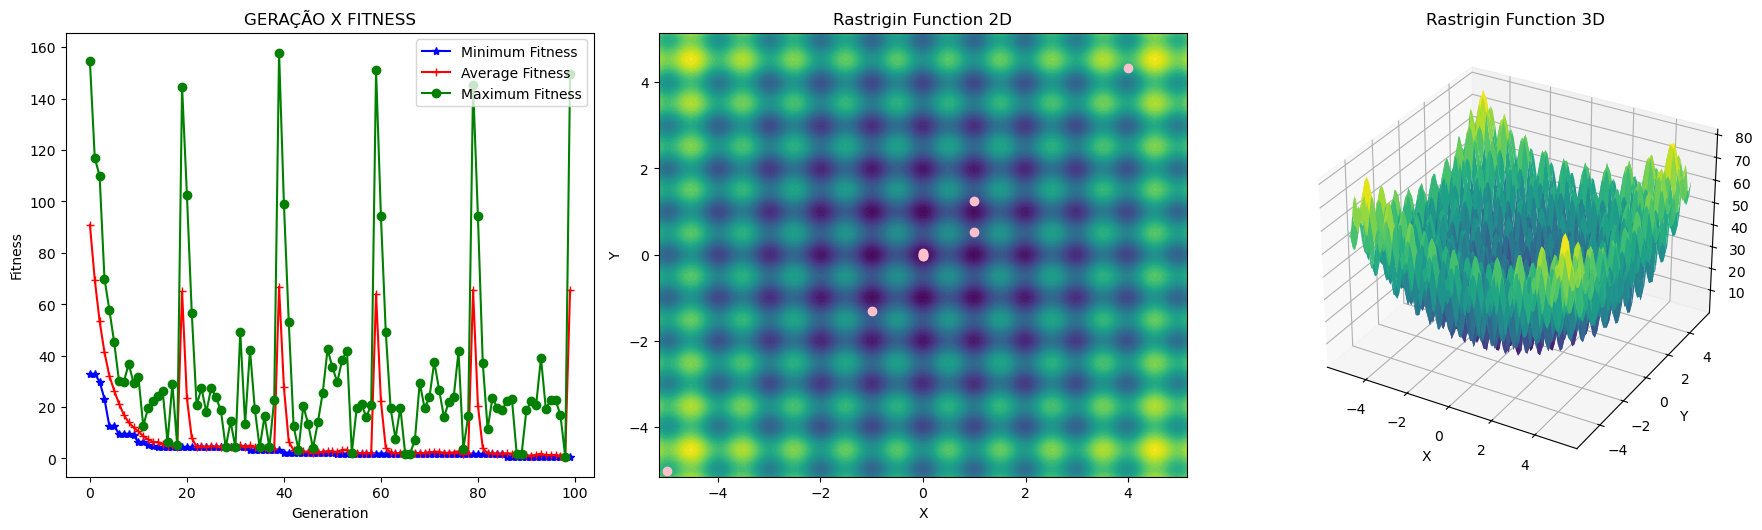

Soluções do problema

Best solution index =  86

Best solution variables =
 [-0.5815355371694118, -0.7435690555805827, 0.6126917538657741, -2.8664963658186036, 4.546026502677276, -4.284030000544545, 3.625539583843824, -4.439870090371569, -5.096097237608297, 1.128672513562444]

Best solution fitness =  0.7527150140181718

Ótimo global da função Rastrigin =  110.43961471644606

Solução ótima global =  [-0.99495904 -0.99495878  0.99495869 -2.98485581  4.97469195 -3.97978399
  3.97978386 -3.97978376 -4.9746912   0.9949588 ]

Porcentagem de proximidade da solução em relação ao ótimo global =  99.31843748644835 %

Distância da solução em relação ao ótimo global = <built-in function abs>


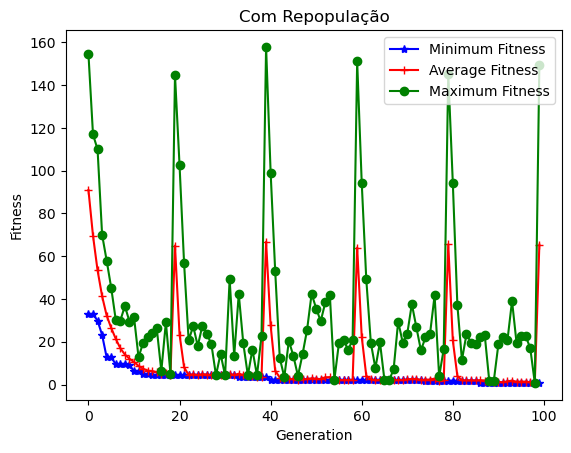

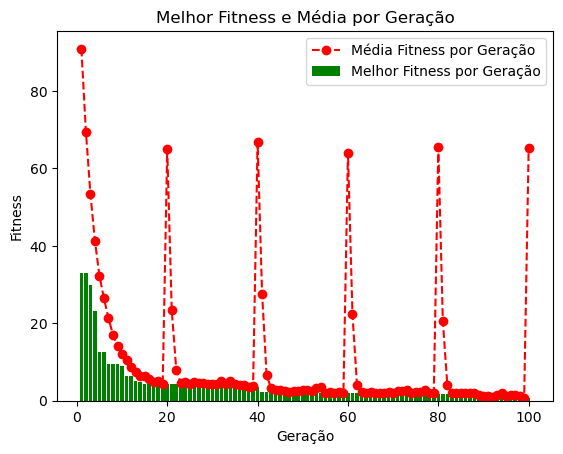

,Generation,Min Fitness,Average Fitness,Max Fitness,Std Fitness
0,0,32.880305,90.932555,154.475272,2.429801e+01
1,1,32.880305,69.536303,116.896789,1.936104e+01
2,2,29.896714,53.413185,109.922399,1.439785e+01
3,3,23.155874,41.297710,70.000365,9.779847e+00
4,4,12.702509,32.258268,57.926704,8.225193e+00
...,...,...,...,...,...
95,95,0.752715,1.409088,22.646808,3.288293e+00
96,96,0.752715,1.360810,22.631925,3.475103e+00
97,97,0.752715,1.102744,17.034152,2.031237e+00
98,98,0.752715,0.752715,0.752715,3.330669e-16


Total execution time: 3.36 seconds


In [373]:
from src.models.AlgEvolution import AlgEvolution

def load_params(file_path):
    with open(file_path, "r") as file:
        params = json.load(file)
    return params

if __name__ == "__main__":
    tempo1 = time.time()

    # Setup
    params = load_params("/home/pedrov/Documentos/GitHub/Engenharia-Eletrica-UFF/Iniciação Cientifica - Eng Eletrica UFF/evolution_rce_master/src/db/parameters.json")
    setup = Setup(params)
    alg = AlgoritimoEvolutivoRCE(setup)
    data_visual = DataExploration()
    # old_alg = AlgEvolution(setup)

    pop_with_repopulation, logbook_with_repopulation, best_variables = alg.run(
        RCE=True,
        fitness_function=rastrigin_decisionVariables,
        decision_variables=(X, y,data_hora,curva,vento),
    )

    print("\n\nEvolução concluída  - 100%")

    # Salvar resultados
    print("\n\nRESULTADOS OBTIDOS")
    data_visual.displayDataFrameInfo(alg.allIndividualValuesArray, "\n\nTodos Individuos Gerados")
    # data_visual.show_conjuntoElite(alg.pop_RCE)
    df = pd.DataFrame(alg.allIndividualValuesArray)
    display(df[df["Generations"]== 20])

    # Visualização dos resultados
    print("\n\nVISUALIZANDO OS RESULTADOS")
    data_visual.show_rastrigin_benchmark(logbook_with_repopulation,best_variables)
    data_visual.visualize(
        logbook_with_repopulation, pop_with_repopulation, repopulation=True
    )
    data_visual.statistics_per_generation_df(logbook_with_repopulation)

    tempo2 = time.time()
    print(f"Total execution time: {round(tempo2-tempo1,2)} seconds")